# Predict y = sin(x1) + sin(x2) with Gaussian Process Regression.
where x2 = x1+1.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

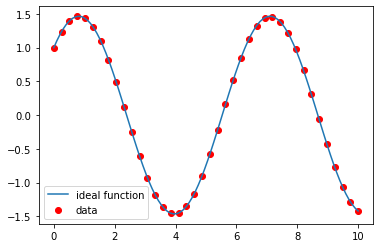

In [2]:
N = 40
x = np.linspace(0,10,100)
x1 = np.linspace(0,10,N)
x2 = x1 + 1.5
y = np.sin(x1) + np.sin(x2)

plt.scatter(x1, np.sin(x1) + np.sin(x2), color='r', label="data")
plt.plot(x, np.sin(x) + np.sin(x+1.5), label='ideal function')
plt.legend()
plt.show()

In [3]:
x_train = np.vstack((x1, x2)).T
y_train = y

In [4]:
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.spatial.distance import cdist

def kee(X, sigma1):
    K = np.zeros((len(X), len(X)))
    K_prime = np.zeros((len(X), len(X)))
    
    length = len(X)
    for i in range(length):
        for j in range(length):
            x1 = np.expand_dims(X[i], axis=1)
            x2 = np.expand_dims(X[j], axis=1)
            d = cdist(x1/sigma1, x2/sigma1, 'sqeuclidean')
            k = np.exp(-0.5*d)
            K[i,j] = np.sum(k)#.mean() #sum ?

            k_prime = k*d/sigma1**3
            K_prime[i, j] = np.sum(k_prime)#.mean()
                
    K_prime = K_prime.reshape([K.shape[0], K.shape[1], 1])
                
    return K, K_prime

def my_kernel_xy(X1, X2, theta=1.0):
    """
    x: N*M array
    """
    K = np.zeros((len(X1), len(X2)))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            for conf1 in x1:
                for conf2 in x2:
                    d = ((conf1-conf2)/theta)
                    tmp = np.exp(-0.5*d**2)
                    K[i, j] += tmp
    return K


class GP():
    """
    A class for Gaussian Process Regression
    """
    def __init__(self, alpha=1e-4, sigma1=1., sigma2=1., bounds=[(1e-5, 1e+2)]):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.bounds = bounds
        self.alpha = alpha
        
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
        def obj_func(sigma1):
            lml, grad = self.log_marginal_likelihood(sigma1)
            return -lml, -grad
        
        opt_res = minimize(obj_func, [self.sigma1], method="L-BFGS-B", jac=True, 
                           bounds=self.bounds)
        
        self.sigma1 = opt_res.x[0]
        self.log_marginal_likelihood_value_ = opt_res.fun

        K, _ = kee(self.X_train, sigma1=self.sigma1)
        K[np.diag_indices_from(K)] += self.alpha

        try:
            self.L_ = cholesky(K, lower=True) 
        except np.linalg.LinAlgError as exc:
            print("The kernel is not returning positive definite matrix")
            print("Try gradually increasing the 'alpha' parameter")
            sys.exit()
        self.alpha_ = cho_solve((self.L_, True), self.y_train)  # Line 3
        
        
    def log_marginal_likelihood(self, sigma1, eval_gradient=True):
        K, K_gradient = kee(self.X_train, sigma1)
        K[np.diag_indices_from(K)] += self.alpha
        try:
            L = cholesky(K, lower=True)  # Line 2
        except np.linalg.LinAlgError:
            print('np.linalg.LinAlgError')
            return (-np.inf, np.zeros_like(theta)) \
                if eval_gradient else -np.inf
        y_train = self.y_train
        if len(y_train.shape)==1:
            y_train = y_train[:, np.newaxis]            
        
        # L is N*N, now needs to be transformed to M*M?
        alpha = cho_solve((L, True), y_train) 

        # Compute log-likelihood (PRML: eq. 6.69)
        log_likelihood_dim = -0.5 * np.einsum("ik,ik->k", y_train, alpha)
        log_likelihood_dim -= np.log(np.diag(L)).sum()
        log_likelihood_dim -= K.shape[0] / 2 * np.log(2 * np.pi)
        log_likelihood = log_likelihood_dim.sum(-1)  # sum over dimensions
        
        # compare Equation 5.9 from GPML
        tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
        tmp -= cho_solve((L, True), np.eye(K.shape[0]))[:, :, np.newaxis]
        log_likelihood_gradient = 0.5 * np.einsum("ijl,ijk->kl", tmp, K_gradient)
        log_likelihood_gradient = log_likelihood_gradient.sum(-1)

        print('log_likelihood:',log_likelihood, log_likelihood_gradient)
        return log_likelihood, log_likelihood_gradient
    
    
    def predict(self, X):
        K_trans = my_kernel_xy(X, self.X_train, self.sigma1)
        y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)

        # decomposition L and its inverse L_inv
        L_inv = solve_triangular(self.L_.T, np.eye(self.L_.shape[0]))
        K_inv = L_inv.dot(L_inv.T)

        # Compute variance of predictive distribution
        K0, _ = kee(X, self.sigma1)
        y_var = np.diag(K0) - np.einsum("ij,ij->i", np.dot(K_trans, K_inv), K_trans)
        
        return y_mean, np.sqrt(np.abs(y_var))

log_likelihood: -5158.898320083095 [-263.43636631]
log_likelihood: -61.705302572162665 [0.]
5.145e+00 1.000e-05 6.171e+01


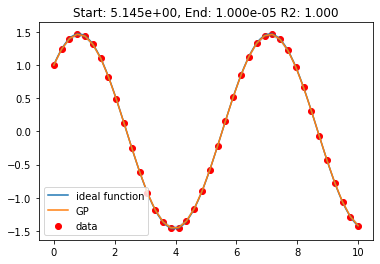

log_likelihood: -48916.826022304034 [-122.07000196]
log_likelihood: -61.705302572162665 [0.]
8.724e+00 1.000e-05 6.171e+01


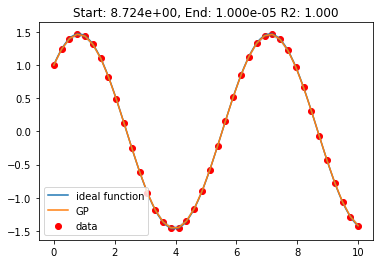

log_likelihood: 83.11782533144783 [-7.33505669]
log_likelihood: -61.705302572162665 [0.]
log_likelihood: 86.27198379066868 [-6.34544985]
log_likelihood: 97.06937726458602 [-2.53697248]
log_likelihood: 99.13455323749949 [-0.68809001]
log_likelihood: 99.27002735712816 [0.03446022]
log_likelihood: 99.27030808126571 [-0.00321443]
log_likelihood: 99.27031057382447 [-1.82648187e-05]
log_likelihood: 99.27031057387762 [9.63750324e-09]
2.782e+00 1.976e+00 -9.927e+01


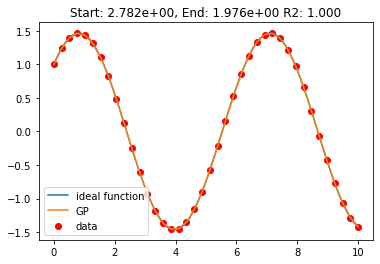

log_likelihood: -26166.724663758087 [-333.64226441]
log_likelihood: -61.705302572162665 [0.]
6.813e+00 1.000e-05 6.171e+01


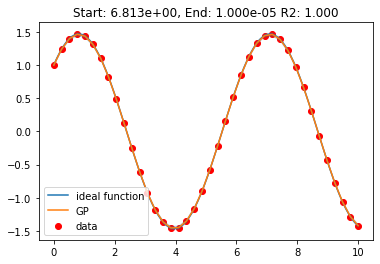

log_likelihood: 99.21308821640054 [-0.45789277]
log_likelihood: 96.17658978157993 [6.81103787]
log_likelihood: 99.22657287921038 [-0.40296756]
log_likelihood: 99.27017847604691 [0.02349526]
log_likelihood: 99.27031008724867 [-0.00142076]
log_likelihood: 99.2703105739007 [-5.49714895e-06]
2.036e+00 1.976e+00 -9.927e+01


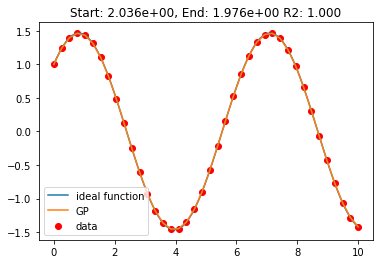

log_likelihood: -42599.330194895876 [-160.39782048]
log_likelihood: -61.705302572162665 [0.]
8.077e+00 1.000e-05 6.171e+01


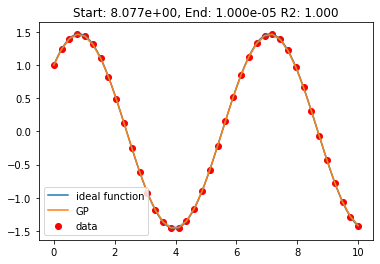

log_likelihood: -7195.41664555536 [-302.59906699]
log_likelihood: -61.705302572162665 [0.]
5.403e+00 1.000e-05 6.171e+01


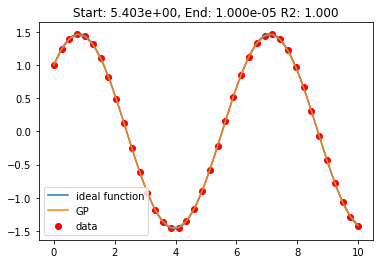

log_likelihood: -45938.60029425732 [-136.96596411]
log_likelihood: -61.705302572162665 [0.]
8.409e+00 1.000e-05 6.171e+01


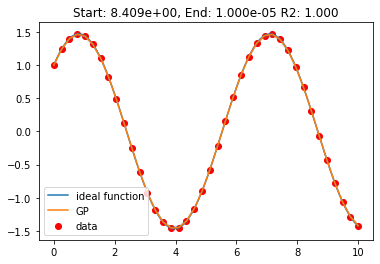

log_likelihood: -56725.768545558676 [-99.37568265]
log_likelihood: -61.705302572162665 [0.]
9.578e+00 1.000e-05 6.171e+01


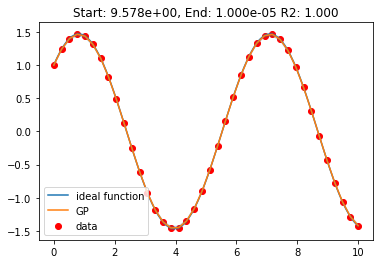

log_likelihood: -6838.311405947583 [-296.34315999]
log_likelihood: -61.705302572162665 [0.]
5.362e+00 1.000e-05 6.171e+01


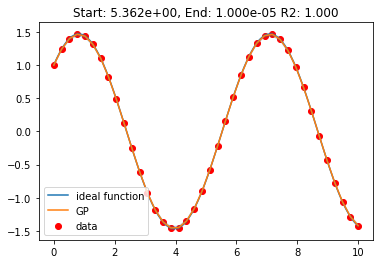

log_likelihood: -3811.585662932255 [-232.28675515]
log_likelihood: -61.705302572162665 [0.]
4.931e+00 1.000e-05 6.171e+01


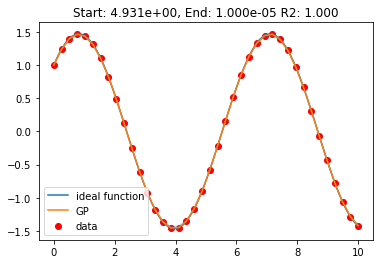

log_likelihood: -45114.81700972506 [-142.05143617]
log_likelihood: -61.705302572162665 [0.]
8.325e+00 1.000e-05 6.171e+01


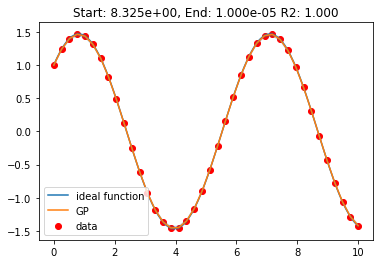

log_likelihood: -238.6758111892385 [-68.29403721]
log_likelihood: -61.705302572162665 [0.]
3.709e+00 1.000e-05 6.171e+01


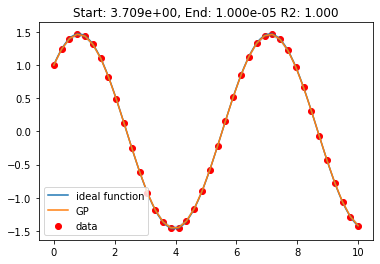

log_likelihood: -14385.95898773156 [-376.4639923]
log_likelihood: -61.705302572162665 [0.]
6.038e+00 1.000e-05 6.171e+01


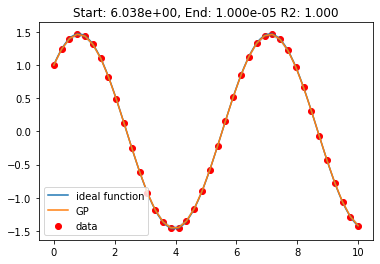

log_likelihood: 9.692143283536609 [-28.0083837]
log_likelihood: -61.705302572162665 [0.]
log_likelihood: 78.5696760136681 [-8.77378346]
log_likelihood: 88.96818379685578 [-5.50235432]
log_likelihood: 97.07435443457521 [-2.53426731]
log_likelihood: 99.18762891988726 [-0.54498839]
log_likelihood: 99.27000527844615 [0.03578546]
log_likelihood: 99.2703086871903 [-0.00279675]
log_likelihood: 99.27031057380898 [-1.65066653e-05]
log_likelihood: 99.27031057388697 [7.5737745e-09]
3.282e+00 1.976e+00 -9.927e+01


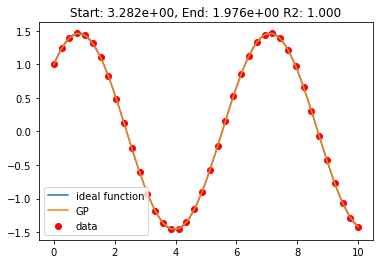

log_likelihood: 90.66061094643678 [-4.96797503]
log_likelihood: -61.705302572162665 [0.]
log_likelihood: 91.80366513285719 [-4.59955141]
log_likelihood: 88.77626561273894 [21.02389509]
log_likelihood: 99.23036262576792 [-0.38592288]
log_likelihood: 99.2702896272134 [-0.00930963]
log_likelihood: 99.2703105041424 [0.00053792]
log_likelihood: 99.27031057392836 [-8.20899132e-07]
2.611e+00 1.976e+00 -9.927e+01


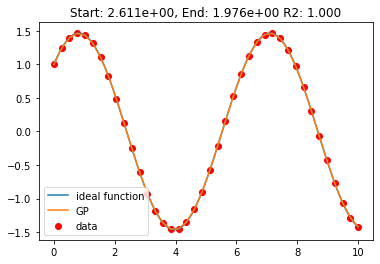

log_likelihood: -57553.36116781913 [-97.53810157]
log_likelihood: -61.705302572162665 [0.]
9.669e+00 1.000e-05 6.171e+01


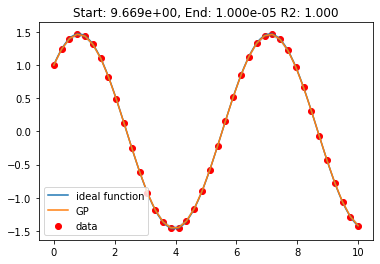

log_likelihood: -48646.182248360434 [-123.21854229]
log_likelihood: -61.705302572162665 [0.]
8.695e+00 1.000e-05 6.171e+01


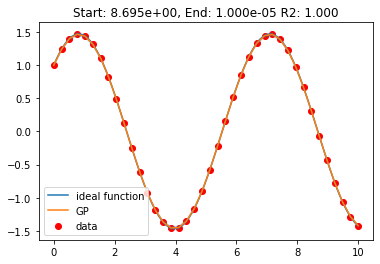

log_likelihood: 91.09396347038751 [-4.82931218]
log_likelihood: -61.705302572162665 [0.]
log_likelihood: 92.15330840948411 [-4.4847888]
log_likelihood: 88.57181759414826 [21.47188427]
log_likelihood: 99.19639828026027 [-0.51688691]
log_likelihood: 99.2702344685813 [-0.01772283]
log_likelihood: 99.27031016133 [0.00130863]
log_likelihood: 99.2703105738569 [-3.79716936e-06]
2.598e+00 1.976e+00 -9.927e+01


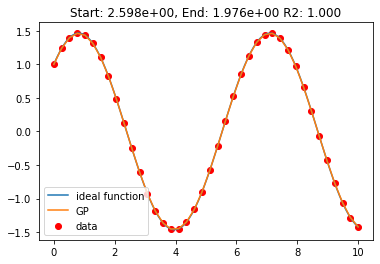

log_likelihood: -37439.0193403007 [-210.08598038]
log_likelihood: -61.705302572162665 [0.]
7.619e+00 1.000e-05 6.171e+01


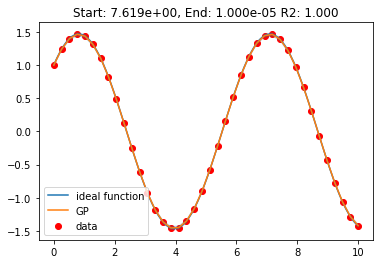

In [5]:
from sklearn.metrics import r2_score

seeds = np.random.RandomState().uniform(1e-2, 1e+1, 20)
for theta0 in seeds:
    reg = GP(alpha=1e-4, sigma1=theta0)
    reg.fit(x_train, y_train)
    y0, y0_var = reg.predict(x_train)
    r2 = r2_score(np.sin(x1) + np.sin(x2), y0)
    print("{:.3e} {:.3e} {:.3e}".format(theta0, reg.sigma1, reg.log_marginal_likelihood_value_))
    plt.title("Start: {:.3e}, End: {:.3e} R2: {:.3f}".format(theta0, reg.sigma1, r2))
    
    plt.scatter(x1, np.sin(x1) + np.sin(x2), color='r', label="data")
    plt.plot(x, np.sin(x) + np.sin(x+1.5), label='ideal function')
    plt.plot(x1, y0, label="GP")
    plt.fill_between(x1, y0-3*y0_var, y0+3*y0_var, alpha=0.3)
    plt.legend()
    plt.show()